#1DCNN code Regression code for Material characterization

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)

# Resources Available for computations

In [0]:
#GPU count and name
!nvidia-smi -L
!lscpu |grep 'Model name'
#no.of sockets i.e available slots for physical processors
!lscpu | grep 'Socket(s):'
#no.of cores each processor is having 
!lscpu | grep 'Core(s) per socket:'
#no.of threads each core is having
!lscpu | grep 'Thread(s) per core'
!lscpu | grep "L3 cache"
#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
!lscpu | grep "MHz"
#memory that we can use
!cat /proc/meminfo | grep 'MemAvailable'
#hard disk that we can use
!df -h / | awk '{print $4}'

##Importing APIs

In [0]:
#imports
%matplotlib inline
import random 
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Activation, Conv1D, MaxPooling1D, Dropout, Lambda, LeakyReLU
from tensorflow.python.keras.optimizers import SGD, Adam, RMSprop
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical,plot_model
from sklearn.metrics import confusion_matrix, classificatioan_report
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

Using TensorFlow backend.


## R^2 coefficient function

In [0]:
#--------------------------------R^2 coefficient for variance------------
#- the higher the R-squared, the better the model fits your data.
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

##Callbacks

In [0]:
#-----------------------------------------callbacks---------------------------
# 1. Epoch Schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_mean_absolute_error')<3) and (logs.get('mean_absolute_error')<3) and (logs.get('val_loss')<18) and (logs.get('loss')<18):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()


# 2. Learning Rate Schedule      
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 2.5))

## Importing data from drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
df_A0 = pd.read_csv('gdrive/My Drive/PhD_Datasets/MATCHARAC_A0_10K_update.txt',header=None)
print(df_A0.shape)

(2719, 4096)


In [0]:
df_S0 = pd.read_csv('gdrive/My Drive/PhD_Datasets/MATCHARAC_S0_10K_update.txt',header=None)
print(df_S0.shape)

(2719, 4096)


In [0]:
df_A0_norm = preprocessing.scale(df_A0, axis = 1)
df_S0_norm = preprocessing.scale(df_S0, axis = 1)

In [0]:
df_prop = pd.read_excel('gdrive/My Drive/PhD_Datasets/prtrb_lamprop_update.xlsx',header=None)
print(df_prop.shape)

(2719, 6)


## Plotting dataset

In [0]:
nfft = 4096
dT = 1e-6
time = np.arange(0,(nfft-0.5)*dT,dT);
print(time.shape)

(4096,)


1770


Text(0, 0.5, 'Amplitude')

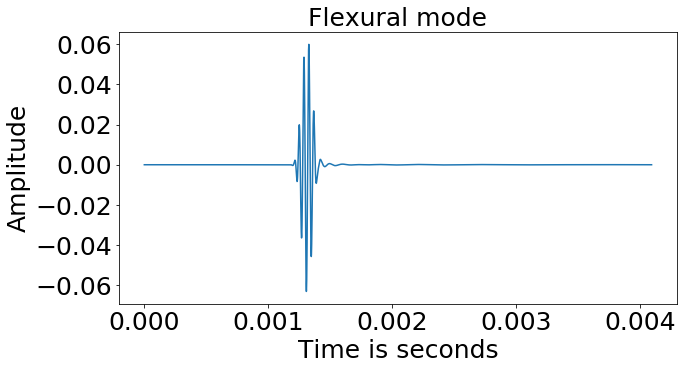

In [0]:
plt.figure(figsize=(10,5))
A0 = random.randint(1,df_A0.shape[0])
plt.plot(time, df_A0.iloc[A0, 0 : df_A0.shape[1]])
plt.title('Flexural mode',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print(A0)
plt.xlabel('Time is seconds',fontsize=25)
plt.ylabel('Amplitude',fontsize=25)

2684


Text(0, 0.5, 'Amplitude')

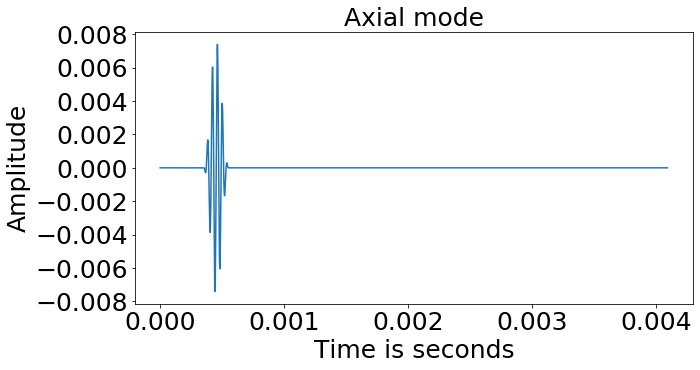

In [0]:
plt.figure(figsize=(10,5))
S0 = random.randint(1,df_A0.shape[0])
plt.plot(time, df_S0.iloc[S0, 0 : df_S0.shape[1]])
plt.title('Axial mode',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
print(S0)
plt.xlabel('Time is seconds',fontsize=25)
plt.ylabel('Amplitude',fontsize=25)

## Deciding Features and Labels

In [0]:
# Input/Features and labels extraction
X1 = df_A0.iloc[:, 0 : df_A0.shape[1]]
X2 = df_S0.iloc[:, 0 : df_S0.shape[1]]
X = np.concatenate([X1,X2], axis=1)
X = np.array(X)

In [0]:
y = df_prop.iloc[:, 0:df_prop.shape[1]-1]
y = np.array(y)

In [0]:
# Shapes of input and output
print(X1.shape)
print(X2.shape)
print(X.shape)
print(y.shape)

(2719, 4096)
(2719, 4096)
(2719, 8192)
(2719, 5)


In [0]:
print(y)

[[1.00000000e+03 5.00000000e+01 5.00000000e+00 2.50000000e-01
  2.50000000e-01]
 [1.00000000e+03 5.00000000e+01 5.00000000e+00 2.50000000e-01
  3.16666667e-01]
 [1.00000000e+03 5.00000000e+01 5.00000000e+00 2.50000000e-01
  4.50000000e-01]
 ...
 [2.50000000e+03 2.50000000e+02 3.50000000e+01 3.83333333e-01
  2.50000000e-01]
 [2.50000000e+03 2.50000000e+02 3.50000000e+01 4.50000000e-01
  3.83333333e-01]
 [2.50000000e+03 2.50000000e+02 5.00000000e+01 4.50000000e-01
  4.50000000e-01]]


##Splitting testing and test set

In [0]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.10, random_state = 42)

In [0]:
# Shapes of training and test tests
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2447, 8192)
(2447, 5)
(272, 8192)
(272, 5)


In [0]:
m_train = X_train.shape[0]
m_test = X_test.shape[0]
n_timesteps = X1.shape[1]
n_features = 2
n_outputs = y_train.shape[1]
print(m_train)
print(m_test)
print(n_timesteps)
print(n_features)
print(n_outputs)

2447
272
4096
2
5


##Reshape the arrays

In [0]:
# reshape the arrays
X_train = np.reshape(X_train, (m_train,n_timesteps,n_features))
X_test  = np.reshape(X_test, (m_test,n_timesteps,n_features))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2447, 4096, 2)
(272, 4096, 2)
(2447, 5)
(272, 5)


## Model Architecture

In [0]:
# define model architecture : 1DCNN-classification
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, input_shape=(n_timesteps,n_features)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(16))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.05))
model.add(Dense(5, activation='linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4094, 16)          112       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4094, 16)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2047, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2045, 32)          1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2045, 32)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1022, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1020, 64)          6

## Choose Hyperparameters

In [0]:
# compile model
model.compile(loss='mse', optimizer=Adam(lr=1e-4, beta_1=0.9, beta_2=0.999), metrics=['mae',r_square])

##Training

In [0]:
# train the model
batchsize = 4
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = batchsize, epochs=500, verbose=1, shuffle = True)

Train on 2447 samples, validate on 272 samples
Epoch 1/500
2447/2447 [==============================] - 10s 4ms/sample - loss: 261987.4580 - mean_absolute_error: 268.9179 - r_square: 0.4210 - val_loss: 45360.5421 - val_mean_absolute_error: 103.0764 - val_r_square: 0.8976
Epoch 2/500
2447/2447 [==============================] - 4s 2ms/sample - loss: 58440.6505 - mean_absolute_error: 138.5825 - r_square: 0.8660 - val_loss: 41511.5326 - val_mean_absolute_error: 84.9484 - val_r_square: 0.9021
Epoch 3/500
2447/2447 [==============================] - 4s 2ms/sample - loss: 56159.9494 - mean_absolute_error: 134.1507 - r_square: 0.8702 - val_loss: 41561.6570 - val_mean_absolute_error: 84.9143 - val_r_square: 0.9011
Epoch 4/500
2447/2447 [==============================] - 4s 2ms/sample - loss: 51879.4145 - mean_absolute_error: 125.5581 - r_square: 0.8806 - val_loss: 41982.8830 - val_mean_absolute_error: 84.7457 - val_r_square: 0.9048
Epoch 5/500
2447/2447 [==============================] - 4s 2m



##Decide Optimum Learning Rate

In [0]:
#-----------------------------------------Finding optimum Learning rate-------------------
lrs=1e-6*(10**(np.arange(15)/2.5))
plt.semilogx(lrs,history.history["loss"])
plt.semilogx(lrs,history.history["val_loss"], label='test_loss')
plt.axis([1e-6,1,0,100000])
plt.legend(['train', 'test'], loc='upper left')

##Plot Accuracy and Loss

###MSE

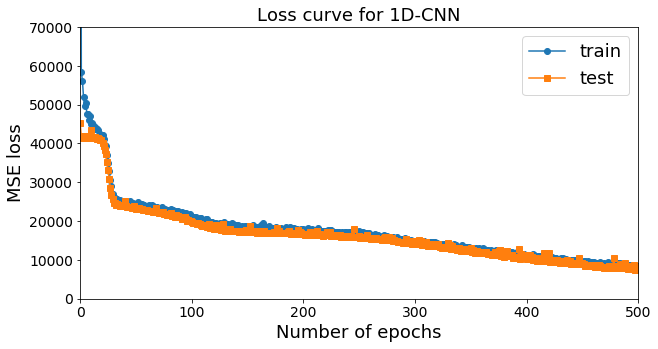

In [0]:
#-----------------------------------------------Summarize history for loss--------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],'-o')
plt.plot(history.history['val_loss'],'-s')
plt.title('Loss curve for 1D-CNN',fontsize=18)
plt.ylabel('MSE loss',fontsize=18)
#plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of epochs',fontsize=18)
plt.legend(['train', 'test'], loc='upper right',fontsize=18)
plt.axis([0,500,0,70000])
plt.show()

###MAE

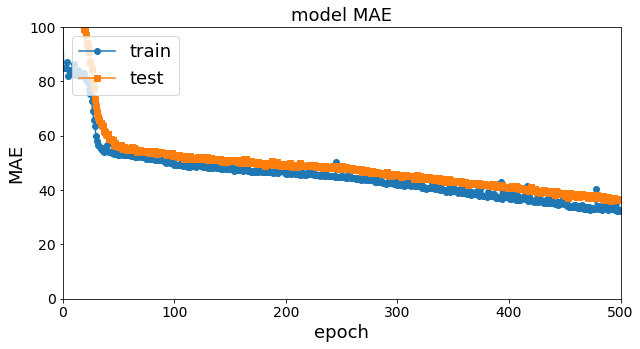

In [0]:
#---------------------------------------Summarize history for MAE------------------------
plt.figure(figsize=(10,5))
plt.plot(history.history['val_mean_absolute_error'],'-o')
plt.plot(history.history['mean_absolute_error'],'-s')
plt.title('model MAE',fontsize=18)
plt.ylabel('MAE',fontsize=18)
plt.xlabel('epoch',fontsize=18)
plt.legend(['train', 'test'], loc='upper left',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis([0,500,0,100])
plt.show()

###R^2 coefficient

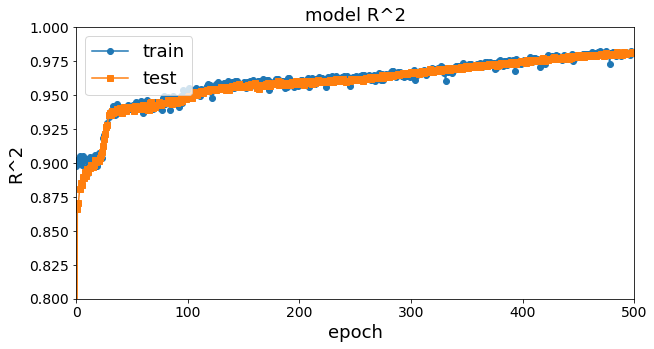

In [0]:
#----------------------------------------Summarize history for R^2------------------------
plt.figure(figsize=(10,5))
plt.plot(history.history['val_r_square'],'-o')
plt.plot(history.history['r_square'],'-s')
plt.title('model R^2',fontsize=18)
plt.ylabel('R^2',fontsize=18)
plt.xlabel('epoch',fontsize=18)
plt.legend(['train', 'test'], loc='upper left',fontsize=18)
plt.axis([0,500,0.8,1.00])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

##Get learned weights and biases

###Weights

In [0]:
layer_weights = model.layers[0].get_weights()[0]
print(layer_weights.shape)
print(layer_weights)

(3, 2, 16)
[[[ 1.4395553   1.7142373  -1.008864   -0.67852145  1.3006877
   -0.8845033  -0.5385515   1.3524944   1.2674711   1.6698319
    1.3874972   1.2127055  -0.65396214 -0.51504815 -0.6966446
    1.6804346 ]
  [ 1.5400095   1.3001686  -0.7400038  -0.8353499   1.3438907
   -0.99836636 -0.6035822   1.4433118   1.4973274   1.1759118
    1.5820863   1.156473   -0.42735547 -0.5852402  -0.83145756
    1.3665731 ]]

 [[ 1.7255317   1.1123421  -0.5009136  -0.5273361   1.1781943
   -0.35232022 -0.5398815   1.4072491   1.0685831   1.6169188
    1.4704425   1.4740261  -0.46848407 -0.882259   -0.2930982
    1.5045773 ]
  [ 1.474888    1.6965325  -0.5837074  -0.6215149   1.2130193
   -0.32104146 -0.83571535  1.5668364   1.6834455   1.4651179
    1.147618    1.4015181  -0.4577395  -0.29488254 -0.5865783
    1.2285253 ]]

 [[ 1.7182473   1.7354745  -0.3452827  -0.37125838  1.274526
   -0.50922924 -0.26949492  1.4092724   1.1951711   1.7469406
    1.3516747   1.2680354  -0.5931194  -0.88163376 -0

###Biases

In [0]:
layer_biases  = model.layers[0].get_weights()[1]
print(layer_biases.shape)
print(layer_biases)

(16,)
[ 0.00527464  0.00534868 -0.02047762 -0.09253436  0.00494309 -0.01798205
 -0.13419408  0.00520184  0.00519632  0.00507503  0.00496084  0.00547669
 -0.13036342 -0.1363889  -0.09960388  0.00517453]


##Prediction on new examples


###Prediction

In [0]:
# Uploading the dataset
df_pred_A0 = pd.read_csv('gdrive/My Drive/PhD_Datasets/MATCHARAC_A0_10K_pred_new.txt',header=None)
#df_pred_A0 = preprocessing.scale(df_pred_A0, axis = 1)
print(df_pred_A0.shape)
df_pred_S0 = pd.read_csv('gdrive/My Drive/PhD_Datasets/MATCHARAC_S0_10K_pred_new.txt',header=None)
#df_pred_S0 = preprocessing.scale(df_pred_S0, axis = 1)
print(df_pred_S0.shape)
df_pred = np.concatenate([df_pred_A0,df_pred_S0], axis=1)
df_pred.shape

(12, 4096)
(12, 4096)


(12, 8192)

In [0]:
df_pred_labels = pd.read_excel('gdrive/My Drive/PhD_Datasets/prtrb_lamprop_pred_new.xlsx',header=None)
df_pred_labels.shape

(12, 6)

In [0]:
# Setting input for prediction
x_predict = df_pred[0:df_pred.shape[0], 0: df_pred.shape[1]]
x_predict = np.array(x_predict)
print(x_predict.shape)
print(x_predict)

(12, 8192)
[[-5.561e-13 -3.042e-08 -5.700e-08 ...  2.233e-11  6.734e-14  2.244e-11]
 [-9.571e-15  4.484e-09  8.463e-09 ...  2.035e-11  1.547e-13  2.045e-11]
 [ 1.943e-13  8.180e-09  1.773e-08 ... -1.827e-11 -1.527e-13 -1.836e-11]
 ...
 [ 5.555e-13 -7.659e-08 -1.541e-07 ...  2.592e-11  1.413e-13  2.605e-11]
 [ 4.441e-13 -6.760e-08 -1.417e-07 ...  3.875e-13 -9.667e-14  3.899e-13]
 [-4.860e-13 -4.002e-08 -7.955e-08 ... -9.519e-12  3.994e-14 -9.567e-12]]


In [0]:
# demonstrating prediction
x_predict = np.reshape(x_predict, (x_predict.shape[0],n_timesteps,n_features))
y_predict = model.predict(x_predict, verbose=1)
y_predict = pd.DataFrame(y_predict)
print(y_predict)

12/12 [==============================] - 0s 1ms/sample
              0           1          2         3         4         5
0   1974.706787  172.213120  27.318230  0.357305  0.281681  2.033124
1   1316.646484  160.953735  27.688274  0.350172  0.307054  2.027230
2   1362.593018  160.206131  27.924826  0.349553  0.305857  2.027740
3    985.360596  138.384567  25.743776  0.345983  0.306045  2.015249
4   1039.747925  148.403931  26.556997  0.348299  0.305751  2.018752
5   1975.805664  174.866440  28.036531  0.364235  0.273366  2.032392
6   2053.831055  176.981644  27.982792  0.366363  0.268401  2.033022
7   1997.466431  196.783478  31.793806  0.365613  0.274738  2.040794
8   2232.538574  201.992645  31.954756  0.368763  0.265611  2.043399
9   2207.549561  180.581985  27.547491  0.361949  0.271441  2.036211
10  1982.819092  173.856247  27.258608  0.360386  0.277604  2.032875
11  2029.712769  171.193405  28.034819  0.357179  0.277518  2.033820


In [0]:
# true output
y_true = df_pred_labels.iloc[:, 0:df_pred_labels.shape[1]]
y_true = pd.DataFrame(y_true)
print(y_true)

       0             1            2     3     4           5
0   1500  160000000000   8970000000  0.28  0.36  6200000000
1   1500  160000000000  25000000000  0.28  0.36  6200000000
2   1500  180000000000   8970000000  0.28  0.36  6200000000
3   1500  180000000000  25000000000  0.28  0.36  6200000000
4   1500  200000000000   8970000000  0.28  0.36  6200000000
5   1500  200000000000  25000000000  0.28  0.36  6200000000
6   2200  160000000000   8970000000  0.28  0.36  6200000000
7   2200  160000000000  25000000000  0.28  0.36  6200000000
8   2200  180000000000   8970000000  0.28  0.36  6200000000
9   2200  180000000000  25000000000  0.28  0.36  6200000000
10  2200  200000000000   8970000000  0.28  0.36  6200000000
11  2200  200000000000  25000000000  0.28  0.36  6200000000


### Importing into excel

In [0]:
 pip install xlsxwriter

In [0]:
import xlsxwriter 
  
workbook = xlsxwriter.Workbook('1DCNN_regression_MATCHAR_10K_new.xlsx') 
  
# By default worksheet names in the spreadsheet will be  
# Sheet1, Sheet2 etc., but we can also specify a name. 
worksheet = workbook.add_worksheet("My sheet") 

worksheet.write(0, 0, 'True values (rho)')
worksheet.write(0, 1, 'Pred. values (rho)')  
worksheet.write(0, 2, 'True values (E1)')
worksheet.write(0, 3, 'Pred. values (E1)')
worksheet.write(0, 4, 'True values (E2)')
worksheet.write(0, 5, 'Pred values (E2)')
worksheet.write(0, 6, 'True values (v12)')
worksheet.write(0, 7, 'Pred. values (v12)')
worksheet.write(0, 8, 'True values (v23)')
worksheet.write(0, 9, 'Pred. values (v23)')  
worksheet.write(0, 10, 'True values (G12)')
worksheet.write(0, 11, 'Pred. values (G12)') 

# columns are indexed from 1. 
row = 1
col = 0

# Iterate over the data and write it out row by row. 
for i in range(0, len(y_true)):
    worksheet.write(row, col, y_true.iloc[i,0])
    worksheet.write(row, col + 1, y_predict.iloc[i,0])
    worksheet.write(row, col + 2, y_true.iloc[i,1])
    worksheet.write(row, col + 3, y_predict.iloc[i,1])
    worksheet.write(row, col + 4, y_true.iloc[i,2])
    worksheet.write(row, col + 5, y_predict.iloc[i,2])
    worksheet.write(row, col + 6, y_true.iloc[i,3])
    worksheet.write(row, col + 7, y_predict.iloc[i,3])
    worksheet.write(row, col + 8, y_true.iloc[i,4])
    worksheet.write(row, col + 9, y_predict.iloc[i,4])
    worksheet.write(row, col + 10, y_true.iloc[i,5])
    worksheet.write(row, col + 11, y_predict.iloc[i,5])
    row += 1
  
workbook.close()

excel = pd.read_excel('1DCNN_regression_MATCHAR_10K_new.xlsx')
print(excel)

    True values (rho)  ...  Pred. values (G12)
0                1500  ...            2.033124
1                1500  ...            2.027230
2                1500  ...            2.027740
3                1500  ...            2.015249
4                1500  ...            2.018752
5                1500  ...            2.032392
6                2200  ...            2.033022
7                2200  ...            2.040794
8                2200  ...            2.043399
9                2200  ...            2.036211
10               2200  ...            2.032875
11               2200  ...            2.033820

[12 rows x 12 columns]
